In [1]:
import pandas as pd
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import SimpleImputer
import numpy as np

In [2]:
df = pd.read_csv('/kaggle/input/prediccion-de-sufrir-enfermedades-coronarias/train.csv')
df_test_public = pd.read_csv('/kaggle/input/prediccion-de-sufrir-enfermedades-coronarias/test_public.csv')
df_test_private = pd.read_csv('/kaggle/input/prediccion-de-sufrir-enfermedades-coronarias/test_private.csv')

In [3]:
X,y = df.drop(['CHD_OR_MI','ID'],axis=1),df[['CHD_OR_MI']] 
x_train,x_val,y_train,y_val = train_test_split(X,y,test_size=0.2)

### Otros enfoques utilizando técnicas de Deep Learning

Aparte de las técnicas de Boosting decidí utilizar otras técnicas de deep learning para intentar superar el f1_score alcanzado.

Lo que no funciono
* Iterative imputer
* Lasso and ridge logistic regression(empleados para clasificación)

Con estas técncias no se superó el f1 score de 0.9


Lo que si funcionó (sin necesidad de aplicar over ni undersampling  ni oversampling)
* Autoencoder (utilizando Keras) + LightGBM | F1_Score Test: 0.9576
* TabNet (es un enfoque de deep learning para trabajar con data tabular) | F1_Score Test: 0.9578

Se descartaron estos modelos por la pérdida de interpretabilidad y porque la implementación de TabNet en Pytorch es bastante limitada lo cual dificulta la optimización de hiperpárametros del modelo.

#### Autoencoder + Modelos de Boosting

Siguiendo una metodología similar a la propuesta por el paper: *A study on using deep autoencoders for imbalanced binary classification* decidí entrenar un *autoencoder* que aprenda una representación latente de la data. Luego recortar el autoencoder y usar ese vector caracteristico para entrenar 3 modelos de boosting. Con este enfoque no era necesario aplicar ni over ni undersampling

In [4]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.regularizers import l1_l2

input_dim = x_train.shape[1]  
encoding_dim = 64 

input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
bottleneck = Dense(encoding_dim, activation='relu')(encoded) # Esta capa  es la que más nos interesa porque luego hacemos el recorte aquí
decoded = Dense(64, activation='relu')(bottleneck)
decoded = Dense(128, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='relu')(decoded)
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, validation_split=0.2)
encoder = Model(inputs=input_layer, outputs=bottleneck)

x_latente_train = encoder.predict(x_train)
x_latente_test = encoder.predict(x_val)

Epoch 1/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: nan - val_loss: nan
Epoch 2/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan - val_loss: nan
Epoch 3/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan - val_loss: nan
Epoch 4/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan - val_loss: nan
Epoch 5/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan - val_loss: nan
Epoch 6/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan - val_loss: nan
Epoch 7/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan - val_loss: nan
Epoch 8/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan - val_loss: nan
Epoch 9/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan - val_loss: nan
Epoch 10/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan - val_loss: nan
Epoch 11/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan - val_loss: nan
Epoch 12/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: nan - val_loss: nan
Epoch 13/50
869/869 ━━━━━━━━━━━━━━━━━

In [5]:
def measure_performate_model_on_test(modelo,x_train,y_train,x_test,y_test):
    modelo.fit(x_train,y_train)
    y_pred = modelo.predict(x_test)
    print(classification_report(y_test,y_pred))
    print('F1 score')
    print(f1_score(y_test,y_pred))

catboost_model = CatBoostClassifier(
    scale_pos_weight=1, # 1
    random_state=42,
    verbose=False)

xgboost_model = XGBClassifier(
    scale_pos_weight=1, 
    random_state=42,
    )  

lightgbm_model = LGBMClassifier(
    scale_pos_weight=1,   
    random_state=42,
    verbose=0)

In [6]:
print('Resultados del catboost con hiperparametros default + Autoencoder')
measure_performate_model_on_test(catboost_model,x_latente_train,y_train,x_latente_test,y_val) 
print('Resultados del xgboost con hiperparametros default + Autoencoder')
measure_performate_model_on_test(xgboost_model,x_latente_train,y_train,x_latente_test,y_val)
print('Resultados del light_gbm con hiperparametros default + Autoencoder')
measure_performate_model_on_test(lightgbm_model,x_latente_train,y_train,x_latente_test,y_val)

Resultados del catboost con hiperparametros default + Autoencoder


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5713
         1.0       0.92      1.00      0.96     63737

    accuracy                           0.92     69450
   macro avg       0.46      0.50      0.48     69450
weighted avg       0.84      0.92      0.88     69450

F1 score
0.9571054232019641
Resultados del xgboost con hiperparametros default + Autoencoder


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_l

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5713
         1.0       0.92      1.00      0.96     63737

    accuracy                           0.92     69450
   macro avg       0.46      0.50      0.48     69450
weighted avg       0.84      0.92      0.88     69450

F1 score
0.9571054232019641
Resultados del light_gbm con hiperparametros default + Autoencoder
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because th

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### TabNet con modificación de la función de pérdida 

In [8]:
!pip install pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import f1_score
from pytorch_tabnet.metrics import Metric
import numpy as np
import torch
import torch.nn.functional as F

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.1 MB/s eta 0:00:00


En el paper *Clash of titans on imbalanced data: TabNet vs 
XGBoost (se encuentra en las referencias) proponen 3 modificaciones a la función de pérdida de TabNet*

Se implementó la Loss Categorical Cross Entropy con una Mean divergence regularization (MDR). Esta debería penalizar al modelo para que se enfoque en la clase más subrepresentada tambien.

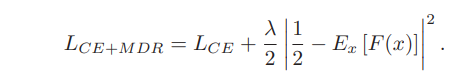

In [9]:
# PyTorch no tiene una metrica de F1score tuve que crear una clase que hereda métodos de la clase Metric de PyTorch
class F1Score(Metric):
    def __init__(self):
        self._name = "f1_score"
        self._maximize = True
    def __call__(self, y_true, y_score):
        y_pred = np.argmax(y_score, axis=1)
        return f1_score(y_true, y_pred, average="binary")

In [10]:
class CE_MDR_Loss(torch.nn.Module):
    def __init__(self, lambda_reg=0.1):
        super(CE_MDR_Loss, self).__init__()
        self.lambda_reg = lambda_reg # este lambda es un hiperparametro de la fórmula de arriba que determina el "peso" de la regularización 
    def forward(self, y_pred, y_true):
        ce = F.cross_entropy(y_pred, y_true)
        mean_pred = torch.mean(torch.softmax(y_pred, dim=1), dim=0) # Se aplica una softmax al vector de salida del modelo (eran un vector con las probabilidades de pertenecer a cada clase)
        mdr_loss = torch.norm(mean_pred - 0.5, p=2)**2 / 2
        perdida_total = ce + self.lambda_reg * mdr_loss
        return perdida_total
personal_loss_function = CE_MDR_Loss(lambda_reg=0.1)

In [13]:
def fit_transform_imputer(imputer,x_train,x_test):
    x_train_imputed = imputer.fit_transform(x_train)
    x_test_imputed = imputer.transform(x_test)
    return x_train_imputed,x_test_imputed

# TabNet solo funciona con imputacion
iterativ_imputer = SimpleImputer(strategy='most_frequent') #usamos la moda porque la mayor parte de las variables son categoricas
x_train_itev,x_val_itev = fit_transform_imputer(iterativ_imputer,x_train,x_val)

In [ ]:
model = TabNetClassifier(optimizer_params=dict(lr=0.02), verbose=1)
model.fit(
    x_train_itev, y_train.to_numpy().reshape(-1),
    eval_set=[(x_val_itev,y_val.to_numpy().reshape(-1))],
    eval_name=["test"],
    eval_metric=[F1Score], # Utilizamos la métrica
    loss_fn=personal_loss_function, # y la función de pérdida personalizada creadas anteriormente
    max_epochs=20,
    patience=3,
    batch_size=256,
    virtual_batch_size=128)

epoch 0  | loss: 0.26134 | test_f1_score: 0.95711 |  0:00:29s
epoch 1  | loss: 0.24082 | test_f1_score: 0.95711 |  0:00:59s
epoch 2  | loss: 0.23888 | test_f1_score: 0.95652 |  0:01:28s
epoch 3  | loss: 0.23765 | test_f1_score: 0.95711 |  0:01:57s

Early stopping occurred at epoch 3 with best_epoch = 0 and best_test_f1_score = 0.95711


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


### Referencias

* Tomescu, V.-I., Czibula, G., & Niţică, Ş. (2021). A study on using deep autoencoders for imbalanced binary classification. Procedia Computer Science, 192, 119-128. https://doi.org/10.1016/j.procs.2021.08.013.

* Kanasz, R., Drotar, P., Gnip, P., & Zoricak, M. (2024). Clash of titans on imbalanced data: TabNet vs XGBoost. 2024 IEEE Conference on Artificial Intelligence (CAI), 320–325. https://doi.org/10.1109/CAI59869.2024.00068